HR-аналитики компании "Работа с заботой" помогают бизнесу оптимизировать управление персооналом. Компания предоставила данные с характеристиками сотрудников и сформулировала следующие задачи:
* Построить модель, которая сможет предсказать уровень удовлетворенности сотрудника на основе данных заказчика. 
* Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
Реализация данных задач позволит компании предсказать отток сотрудников. Это важно, так как внизапное увольненние несут в себе риски для компании.

In [5]:
# Импорт необходимых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

# импорт библиотек для работы с моделью
# методы масштабирования
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler 

# методы кодирования 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder 
from sklearn.preprocessing import LabelEncoder

# подготовка модели
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 

# модели
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.svm import SVC

# перебор параметров
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# оценка модели
import shap
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error 

import scipy.stats as stats

In [6]:
# данные для задачи 1
try:
    test_features = pd.read_csv('/Users/....csv', sep=',', decimal='.') # путь к файлу на компьютере, для работы оффлайн    
except:
    test_features = pd.read_csv('https://....csv', sep=',', decimal='.') # если путь к файлу на компьютере не доступен, работа с файлом ведется с сайта яндекса
try:
    test_target_sat = pd.read_csv('/Users/....csv', sep=',', decimal='.')    
except:
    test_target_sat = pd.read_csv('https://....csv', sep=',', decimal='.')
try:
    train_feature_sat = pd.read_csv('/Users/....csv', sep=',', decimal='.')
except:
    train_feature_sat = pd.read_csv('https://....csv', sep=',', decimal='.')

# данные для задачи 2
try:
    train_quit= pd.read_csv('/Users/....csv', sep=',', decimal='.')
except:
    train_quit = pd.read_csv('https://.....csv', sep=',', decimal='.')
try:
    test_target_quit = pd.read_csv('/Users/....csv', sep=',', decimal='.')
except:
    test_target_quit = pd.read_csv('https://....csv', sep=',', decimal='.')

# Задача 1: предсказание уровня удовлетворенности сотрудников

## Предобработка данных

Для построения первой модели необходимо использовать таблицы:       
test_features - входные признаки тестовой выборки (Таблица test_features)  
train_feature_sat - тренировочная выборка (Таблица train_job_satisfaction_rate)  
test_target_sat - целевой признак тестовой выборки (Таблица test_target_job_satisfaction_rate)

*По условию задачи пропуски необходимо заполнить в пайплайне.

### Основная информация о таблицах

In [7]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Таблица test_features cодержит 9 столбцов. Есть пропуски в столбцах "отдел, в котором работает сотрудник" (dept) и "уровень занимаемой должности" (level).  

In [8]:
test_target_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


В таблице с целевым признаком пропусков нет. 

In [9]:
train_feature_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


В таблице c тренировочной выборкой пропусков значений нет. 

Выведем по пять строк каждой таблицы.

In [10]:
test_features.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [11]:
test_target_sat.head(5)

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [12]:
train_feature_sat.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


### Проверка на неявные дубликаты 

Для проверки на неявные дубликаты будем использовать цикл.

In [13]:
for col in test_features.select_dtypes(include='object').columns:
    print('Уникальные значения в столбце', col)
    print(test_features[col].unique())
    print()

Уникальные значения в столбце dept
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Уникальные значения в столбце level
['junior' 'middle' 'sinior' nan]

Уникальные значения в столбце workload
['medium' 'low' 'high' ' ']

Уникальные значения в столбце last_year_promo
['no' 'yes']

Уникальные значения в столбце last_year_violations
['no' 'yes']



In [14]:
for col in train_feature_sat.select_dtypes(include='object').columns:
    print('Уникальные значения в столбце', col)
    print(train_feature_sat[col].unique())
    print()

Уникальные значения в столбце dept
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Уникальные значения в столбце level
['junior' 'middle' 'sinior' nan]

Уникальные значения в столбце workload
['medium' 'high' 'low']

Уникальные значения в столбце last_year_promo
['no' 'yes']

Уникальные значения в столбце last_year_violations
['no' 'yes']



**<span style='color: green;'>Вывод:  
неявных дубликатов не обнаружено. Названия переменных между тестовой и тренировочной выборками совпадают. 
Но пропуски в данных (test_features['dept'], test_features['workload']) есть в двух формах: nan и пустая ячейка с пробелом.</span>**  

Изучим эти строки, возможно, это одна строка.

In [15]:
test_features [(test_features ['dept'].apply(lambda x: ' ' in str(x))) | (test_features ['workload'].apply(lambda x: ' ' in str(x)))]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


Пропуски в разных строках. Обработаем данные значения в Пайплайн, инструментами Энкодера

In [17]:
test_features ['dept'].unique() # проверка

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

In [18]:
test_features ['workload'].unique() # проверка

array(['medium', 'low', 'high', ' '], dtype=object)

**<span style='color: green;'>Вывод:  
теперь в данных содержатся только пропуски nan.</span>**

### Проверка на явные дубликаты

In [19]:
test_features.duplicated().sum()

0

In [20]:
test_target_sat.duplicated().sum()

0

In [21]:
train_feature_sat.duplicated().sum()

0

**<span style='color: green;'>Вывод:  
явные дубликаты в данных не обнаружены.</span>**

## Исследовательский анализ данных

### Распределение количественных данных тренировочной выборки

Для визуализации количественных данных будем использовать гистограммы распределения.  
Для удобства составим функцию.

In [22]:
def plot_histogram(dataframe, column_name, bins=10):  # функция для построения гистограмм распределения
    dataframe[column_name].hist(bins=bins, figsize=(5, 5))
    plt.xlabel(column_name)
    plt.ylabel('Частота')
    plt.show()
    stat = dataframe[column_name].describe() # дополнительно выведим параметры описательной статистики
    print(stat)

#### Длительность работы в компании.

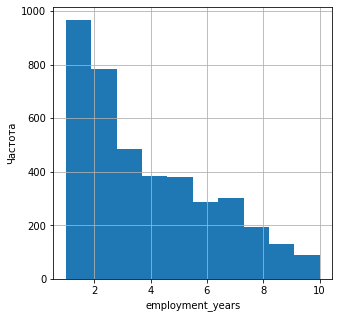

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [23]:
plot_histogram(train_feature_sat, 'employment_years', bins=10)

Распределение прибывания сотрудников в компании имеет скошенную форму. Больше всего сотрудников с небольшим стажем работы в компании, чем выше стаж, тем меньше сотрудников. Медиана приходится на 3 года. 
Выбросов или слишком малых значений в данных нет.

#### Оценка качества работы сотрудника, которую дал руководитель.

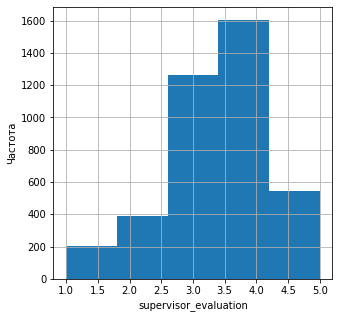

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [24]:
plot_histogram(train_feature_sat, 'supervisor_evaluation', bins=5)

Оценка в компании идет по пятибальной системе, медиана распределения приходится на оценку 4.    

#### Ежемесячная зарплата сотрудника

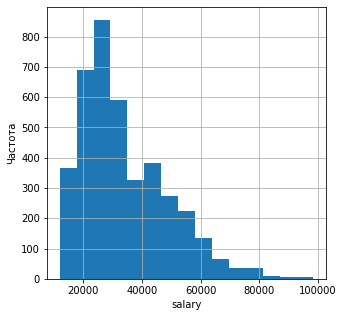

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64


In [25]:
plot_histogram(train_feature_sat, 'salary', bins=15)

Распределение зарплат скошено, большая часть сотрудников получает зарплату до 43 тыс. Медиана зарплаты в компании составляет 30 тыс.

#### Уровень удовлетворенности сотрудника (целевая переменная)

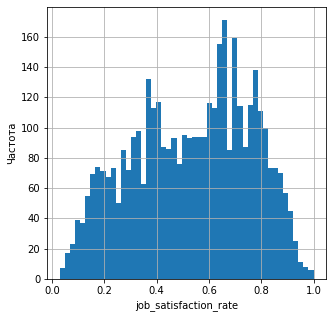

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


In [26]:
plot_histogram(train_feature_sat, 'job_satisfaction_rate', bins=50)

Уровень удовлетворенности сотрудников в компании оценивается от 0 до 1, где 1 это максимальная удовлетворенность. Среднее и медиана распределения совпадают и составляют приблизительно 0.5.   
Целевой признак это количественная переменная.

### Анализ качественных признаков в тренировочной выборке

Для визуализации качественных данных будем использовать столбчатые диаграммы. Выведем столбчатые диаграммы сразу для всех столбцов таблицы.

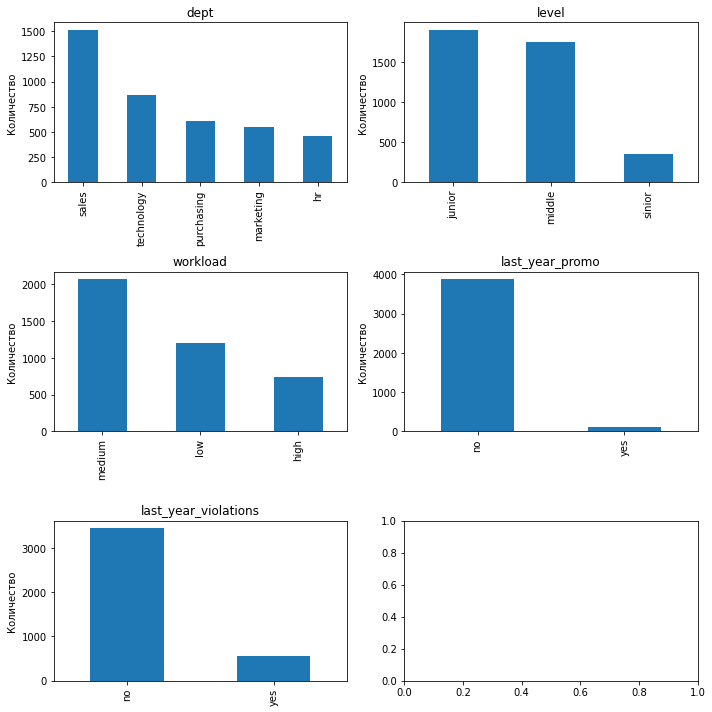

In [27]:
object_columns = train_feature_sat.select_dtypes(include='object').columns

num_cols = 2 # количество столбцов
num_rows = 3 # строк

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10)) #создаем поле для графика
axes = axes.flatten() # преобразуем двухмерный массив, так как графиков 5 другого варианта не получилось

for i, col in enumerate(object_columns): # рисуем график для каждого столбца
    ax=axes[i]
    train_feature_sat[col].value_counts().plot(kind='bar', ax=axes[i], title=col)
    axes[i].set_ylabel('Количество')
    axes[i].set_xlabel('')

plt.tight_layout() # настройка интервала между графиками
plt.show()

* В данных больше всего представлены сотрудники, которые работают в отделе продаж, меньше всего HR.  
* По уровню занимаемой должности больше всего представлены начинающие специальситы (junior), меньше всего sinior. Данные в этом столбце можно считать порядковыми.
* Средний уровень загруженности сотрудников наиболее распространен в компании, меньше всего высоко загруженных сотрудников. В этом столбце также данные порядковые.
* В данных о повышении сотрудников большой перекос в сторону отсутсвия повышения.
* По нарушениям также большой перекос данных, большая часть сотрудников не нарушает правил.

**<span style='color: green;'>Вывод по тренировочной выборке:</span>**   
**<span style='color: green;'> * Целевой признак является количественным. Построение моделей классификации не подходит. Для реализации задачи необходимо использовать регрессионные модели.</span>**   
**<span style='color: green;'> * Для количественных данных необходимо использовать масштабирование, так как данные разных порядков.</span>**   
**<span style='color: green;'> * Для кодирования качественных данных в столбцах level и workload можно использовать OrdinalEncoder.</span>**  
**<span style='color: green;'> * Для всех остольных категориальных переменных надо использовать OneHotEncoder.</span>**

### Распределение количественных данных в тестовой выборке

Проанализируем данные в тестовой выборке, чтобы быть уверенным, что с данными все впорядке.

#### Длительность работы в компании

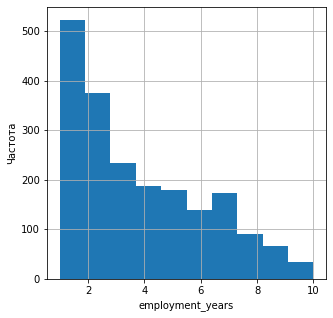

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [28]:
plot_histogram(test_features, 'employment_years', bins=10)

Распределение для тестовой выборки сходно с распределением для тренировочной выборки, разброс значений также укладывается в диапазон от года до десяти лет. Значения медиан совпадают.

#### Оценка качества работы сотрудника, которую дал руководитель.

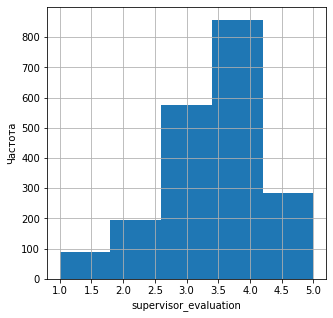

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [29]:
plot_histogram(test_features, 'supervisor_evaluation', bins=5)

Распределение сходно с тренировочной выборкой, используется такая же пятибальная система. Медиана распределения соответстует оценке 4. 

#### Ежемесячная зарплата сотрудника

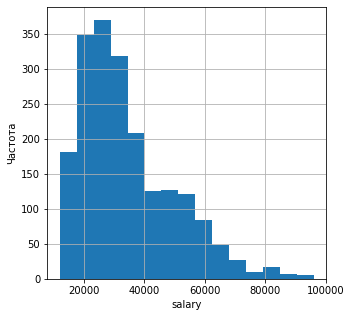

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [30]:
plot_histogram(test_features, 'salary', bins=15)

Распределение для зарплат также сходно между выборками. Медианы совпадают и средние значения между выборками совадают.

### Анализ качественных признаков в тестовой выборки

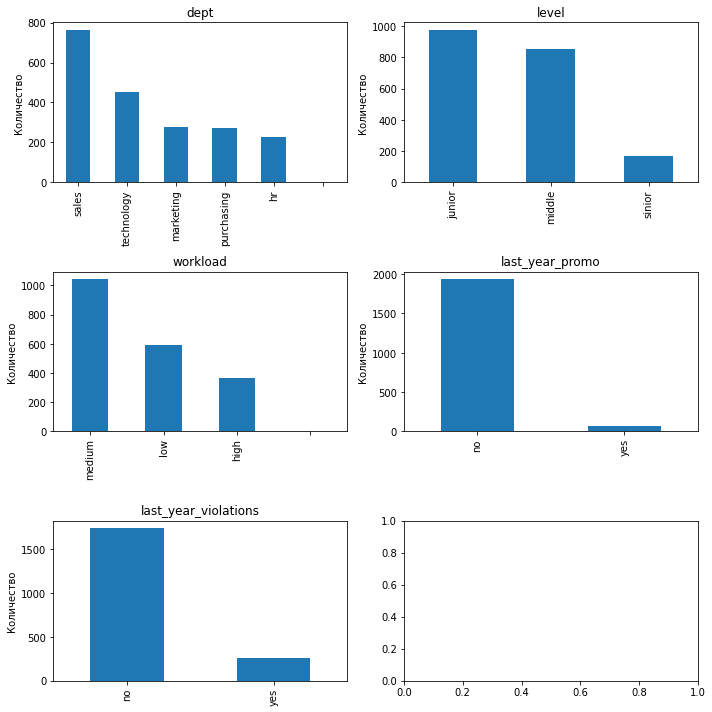

In [31]:
object_columns2 = test_features.select_dtypes(include='object').columns

num_cols = 2 # количество столбцов
num_rows = 3 # строк

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10)) #создаем поле для графика
axes = axes.flatten() # преобразуем двухмерный массив, так как графиков 5 другого варианта не получилось

for i, col in enumerate(object_columns2): # рисуем график для каждого столбца
    ax=axes[i]
    test_features[col].value_counts().plot(kind='bar', ax=axes[i], title=col)
    axes[i].set_ylabel('Количество')
    axes[i].set_xlabel('')

plt.tight_layout() # настройка интервала между графиками
plt.show()

Распределение качественных переменных в тренировочной и тестовой выборках сопоставимо.

### Анализ целевого признака для тестовой выборки

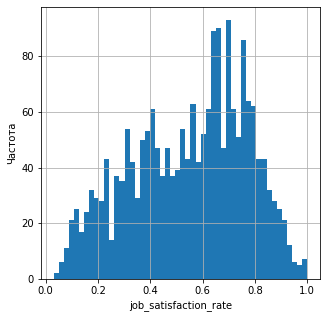

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64


In [32]:
plot_histogram(test_target_sat, 'job_satisfaction_rate', bins=50)

В распределении целевого признака тестовой выборки также нет каких-либо отклонений.

**<span style='color: green;'>Вывод:  
наборы данных тренировочной и тестовой выборок сопоставимы по своей структуре.</span>** 

### Корреляционный анализ

Дополнительно проведем корреляционный анализ. Будем использовать библиотеку phik, это позволит нам сразу увидеть взаимосвязь всех признаков.

In [33]:
train_for_phik=train_feature_sat.drop(columns=['id'])
phik_overview = train_for_phik.phik_matrix(interval_cols=['employment_years', 'supervisor_evaluation', 'salary'])


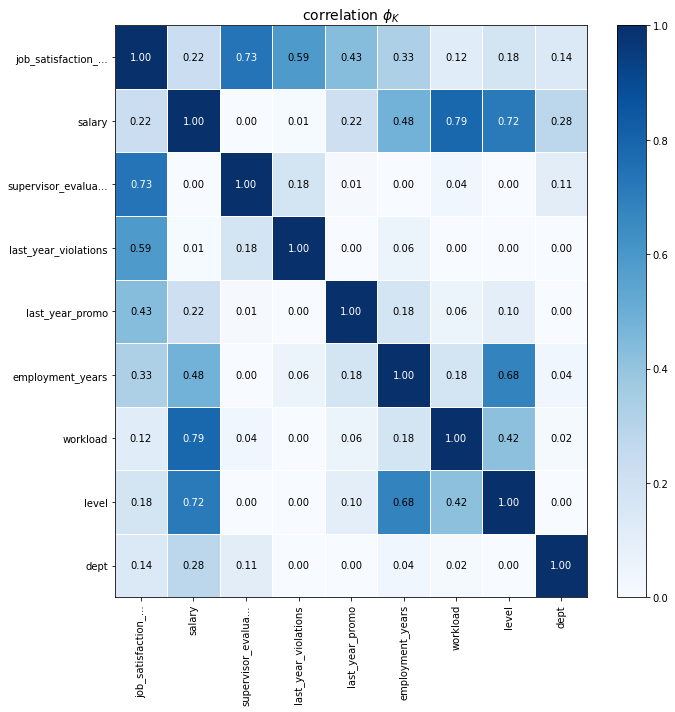

In [34]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10,10)
)
plt.tight_layout()

**<span style='color: green;'>Вывод:  
Целевой признак job_satisfaction_rate плохо коррелирует с признаками workload, level, dept.
На данном этапе не будем ничего менять, но если подобрать модель не получится, то имеет смысл попробовать удалить признаки, с которыми целевая переменная имеет слабую линейную связь.</span>**

## Подготовка данных

Так как целевой признак является количественными, необходимо использовать модели регрессионного анализа. 
По условию задачи необходимо использовать одну линейную модель, а в качестве второй - дерево решений.  
Для линейных моделей будем использовать два кодировщика: если качественный признак номинативный то OneHotEncoder, если качественный признак порядковый, то OrdinalEncoder. 
Для работы с пропусками будем использовать SimpleImputer, заполнять пропуски будем наиболее часто встречаемыми значениями.  
Пропуски, заданные пробелом в данных, были обработаны ранее, но в пайплайне оставим параметр handle_unknown.
Для OneHotEncoder значение параметра будет 'ignore', для игнорирования неизвестных категорий.  
Для OrdinalEncoder значение параметра будет 'use_encoded_value', несзвестные значения будут превращаться в nan и следующим шагом заполняться через SimpleImputer.

Перед началом построения пайплайна, сделаем индексами в таблицах столбец id. Отсортируем таблицы по id.

In [35]:
train_feature_sat.set_index('id', inplace=True)
train_feature_sat.sort_index(inplace=True)

In [36]:
train_feature_sat.head(5) # проверка

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100954,purchasing,junior,low,1,no,no,4,15600,0.60
101057,sales,junior,low,1,no,yes,4,19200,0.45
101074,sales,junior,medium,2,no,no,2,20400,0.36
101081,sales,middle,low,2,no,no,4,28800,0.66
101129,technology,junior,medium,1,no,no,4,34800,0.71


In [37]:
train_feature_sat.duplicated().sum()

245

In [38]:
test_features.set_index('id', inplace=True)
test_features.sort_index(inplace=True)

In [39]:
test_features.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [40]:
test_target_sat.set_index('id', inplace=True)
test_target_sat.sort_index(inplace=True)

In [41]:
test_target_sat.head(5)

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


### Pipeline для подготовки данных

In [43]:
# задаем параметры для разделения данных
RANDOM_STATE = 42 
TEST_SIZE = 0.25

X = train_feature_sat.drop(['job_satisfaction_rate'], axis=1)  # признаки (features)
y = train_feature_sat['job_satisfaction_rate']  # целевой признак (target)

# создаем списки с названиями признаков

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations'] # кодируем номинативные признаки
ord_columns = ['level', 'workload'] # кодируем порядковые признаки
num_columns = ['employment_years', 'supervisor_evaluation', 'salary'] # кодируем количественные признаки

# подготовка данных

# подготовка признаков из списка ohe_columns: заполняем пропуски наиболее частыми значениями и кодируем переменные OneHotEncoder
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown = 'ignore', sparse_output = False))
    ]
)

# подготовка признаков из списка ord_columns: заполнение пропусков и кодирование переменных OrdinaryEncoder
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
      ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['medium', 'low', 'high'],
                ],
                handle_unknown='use_encoded_value' , unknown_value=np.nan
      )
      ),
      ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
      ]
)

# создаем общий пайплайн для подготовки данных и модель
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ]
)
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

## Обучение моделей

Для обучения необходимо использовать минимум две модели. Одна линейная и дерево решений.   
В качестве линейной модели будем использовать SVR (support Vector Regression) модель.  
Для модели SVR будем подбирать следующие гиперпараметры: тип ядра (линейное и радиальное базисное ядро), значение С.  
Для дерева решений будем использовать модель DecisionTreeRegressor с гиперпараметрами глубина дерева и максимальное количество признаков для расщепления.
Для оценки качества модели будет использована метрика SMAPE (симметричное среднее абсолютное процентное отклонение). 

#### Метрика SMAPE

Перед обучением моделей и подбором гиперпараметров создадим функцию для расчета метрики SMAPE.

In [44]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2.0))
smape_scorer = make_scorer(smape, greater_is_better=False)

#### Обучение модели. Первый круг.

In [45]:
# создаем словари для разных моделей

param_grid = [
    # DecisionTreeRegressor
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,30), # максимальная глубина дерева
        'models__max_features': range (2, 10), # максимальное количество признаков, которое следует рассмотреть при поиске лучшего расщепления
        'preprocessor__num': [MinMaxScaler()],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },
    # SVR (регрессия опорных векторов)

    {
        'models': [SVR()],
        'models__kernel':['linear', 'rbf'], # тип ядра
        'models__C':[0.1, 2, 5, 10, 20],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    }
]

grid_tree=GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1,
    error_score='raise',
)

grid_tree.fit(X, y)

print('Лучшая модель и её параметры:\n\n', grid_tree.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_tree.best_score_)
print('Лучшие гиперпараметры модели:', grid_tree.best_params_)



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before

#### Рейтинг проверенных моделей

Рассмотрим 10 лучших моделей.

In [46]:
model_cv_result = pd.DataFrame(grid_tree.cv_results_)
model_cv_result = model_cv_result.sort_values(['rank_test_score'])
pd.set_option('display.max_colwidth', None)
model_cv_result[['mean_test_score', 'rank_test_score', 'params', 'std_test_score']].head(5)

,mean_test_score,rank_test_score,params,std_test_score
230,-14.539921,1,"{'models': SVR(), 'models__C': 2, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.395336
234,-14.562997,2,"{'models': SVR(), 'models__C': 5, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.495179
238,-14.651711,3,"{'models': SVR(), 'models__C': 10, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.581012
242,-14.832794,4,"{'models': SVR(), 'models__C': 20, 'models__kernel': 'rbf', 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.571739
125,-15.255657,5,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 17, 'models__max_features': 7, 'preprocessor__num': MinMaxScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.750951


#### Проверка модели на тестовой выборке

In [47]:
job_satisfaction_prediction = grid_tree.best_estimator_.predict(test_features)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [48]:
test_features['job_satisfaction_prediction'] = job_satisfaction_prediction

In [49]:
smape_final = smape(test_target_sat['job_satisfaction_rate'], test_features['job_satisfaction_prediction'])

In [50]:
smape_final

13.805919424883347

При подборе гиперпараметров всё время лучшей моделью оказывалась DessionTreeRegression, но необходимого порога достигнуть не удавалось. Было принято решение ввести дополнительный параметр в SVR модель - тип ядра kernel Radial Basis Function (rbf). После этого модель сразу достигла необходимого порога качества (SMAPE<15), как на тренировочной, так и на тестовой выборках. 

#### Важность признаков

Изучим важность признаков для модели. Будем использовать столбчатую диаграмму SHAP, которая отражает общий вклад признаков в прогнозы модели.

In [ ]:
# Получаем предсказания модели
model = grid_tree.best_estimator_.named_steps['models']

# Используем masker для создания объекта маски
masker = shap.maskers.Independent(X_test_transform)

# Выбираем случайную подвыборку с 1000 образцов
X_test_sample = shap.sample(X_test_transform, 5000)

# Создаем объяснитель с помощью KernelExplainer
explainer = shap.KernelExplainer(model.predict, masker)

# Получаем SHAP-значения для подвыборки
shap_values = explainer.shap_values(X_test_sample)

In [51]:
# Преобразуем данные тестовой выборки
X_test_transform = grid_tree.best_estimator_.named_steps['preprocessor'].transform(test_features)
X_test_sample = shap.sample(X_test_transform, 1000)
masker = shap.maskers.Independent(X_test_sample)
explainer = shap.Explainer(grid_tree.best_estimator_.named_steps['models'].predict, masker, seed=RANDOM_STATE)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [52]:
# получаем значения shap_values (около 6 минут).
shap_values = explainer(X_test_transform)

PermutationExplainer explainer: 2001it [30:12,  1.10it/s]                           


In [53]:
# Получаем имена признаков из ColumnTransfermer
preprocessor = grid_tree.best_estimator_.named_steps['preprocessor']

In [54]:
# преобразуем имена
feature_names = preprocessor.get_feature_names_out()
feature_names = feature_names.tolist()
shap_values_new = shap_values
shap_values_new.feature_names = feature_names

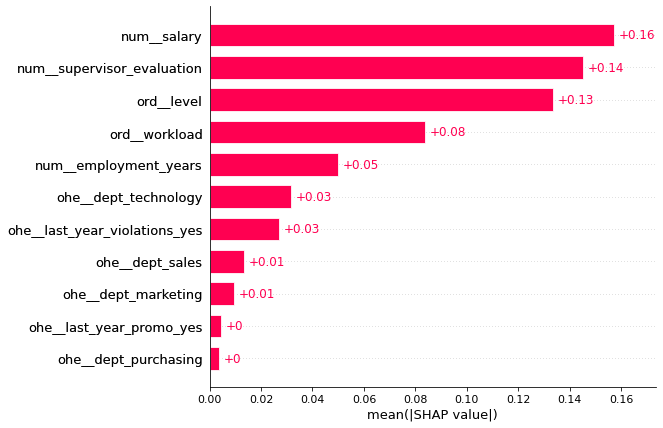

In [55]:
shap.plots.bar(shap_values_new, max_display=18)

Наиболее важными признаками для предсказания удовлетворенности сотрудников с точки зрения модели являются:  
зарплата сотрудника,
оценка качества работы сотрудника, которую дал руководитель,    
уровень занимаемой должности,  
уровень загруженности сотрудника.

## Выводы

**<span style='color: green;'>Лучшей моделью для предсказания уровня удовлетворенности сотрудников оказалась модель регрессии на основе метода опорных векторов. Параметры лучшей модели следующие: нелинейное ядро радиальной базисной функции (Radial Basis Function) и гиперпараметр  C=2.</span>**  

Модель SVR с ядром rbf могла оказаться лучшей, так как она лучше захватывает сложные нелинейные зависимости, лучше работает в условиях шума в данных. В модель были включены три признака, которые имеют слабую линейную связь с целевым признаком, что видно из корреляционного анализа. Деревья решений требуют более четкой настройки гиперпараметров. Возможно, если включить дополнительные гиперпараметры и исключить признаки со слабой связью, удалось бы настроить модель дерева решений.  
Кроме того, когда количество признаков небольшое, но при этом большое количество значений признаков лучше справляется как раз модель опорных векторов с нелинейным ядром.

# Задача 2: предсказание увольнения сотрудников из компании

## Загрузка данных

Все данные были загружены в начале проекта.

## Предобработка данных

Для построения второй модели необходимо использовать следующие данные:       
test_features - входные признаки тестовой выборки (Таблица test_features)  
train_quit - тренировочная выборка (Таблица train_quit)  
test_target_quit - целевой признак тестовой выборки (Таблица test_target_quit)

### Основная информация о таблицах

In [56]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


В таблице train_quit содержится 10 столбцов. Пропусков в столбцах нет.

In [57]:
train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [58]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


В таблице train_quit содержится 2 столбца. Пропусков в столбцах нет.

In [59]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 100298 to 999029
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   dept                         1998 non-null   object 
 1   level                        1999 non-null   object 
 2   workload                     2000 non-null   object 
 3   employment_years             2000 non-null   int64  
 4   last_year_promo              2000 non-null   object 
 5   last_year_violations         2000 non-null   object 
 6   supervisor_evaluation        2000 non-null   int64  
 7   salary                       2000 non-null   int64  
 8   job_satisfaction_prediction  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


Таблица test_features использовалась ранее. Столбец id перенесен в индексы.

### Проверка на неявные дубликаты

In [60]:
for col in train_quit.select_dtypes(include='object').columns:
    print('Уникальные значения в столбце', col)
    print(train_quit[col].unique())
    print()

Уникальные значения в столбце dept
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Уникальные значения в столбце level
['middle' 'junior' 'sinior']

Уникальные значения в столбце workload
['high' 'medium' 'low']

Уникальные значения в столбце last_year_promo
['no' 'yes']

Уникальные значения в столбце last_year_violations
['no' 'yes']

Уникальные значения в столбце quit
['no' 'yes']



Неявных дубликатов в таблице нет, названия признаков совпадают с таблицами из задачи 1.

In [61]:
test_target_quit['quit'].unique()

array(['yes', 'no'], dtype=object)

Неявных дубликатов нет, quit принимает только два значения yes или no.

### Проверка на явные дубликаты

In [62]:
test_target_quit.duplicated().sum()

0

In [63]:
train_quit.duplicated().sum()

0

Явных дубликатов в новых данных нет.

**<span style='color: green;'>Вывод:  
Неявных и явных дубликатов в новых данных нет.  
Названия признаков соответствуют названиям из таблиц задачи 1.  
Пропущенных значений в новых данных нет.</span>**

## Исследовательский анализ данных

### Исследовательский анализ данных признаков из таблицы train_quit

Для исследовательского анализа количественных признаков будем использовать функции из предыдущей задачи.

#### Длительность работы в компании

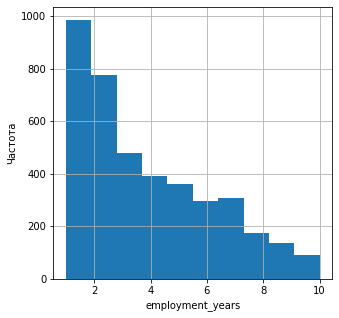

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


In [64]:
plot_histogram(train_quit, 'employment_years', bins=10)

Распределение данных сходно с распределением данных из предыдущей задачи. Значение медианы состаляет 3 года. Разброс значений укладывается в диапазон от года до десяти лет.

#### Оценка качества работы сотрудников, которую дал руководитель

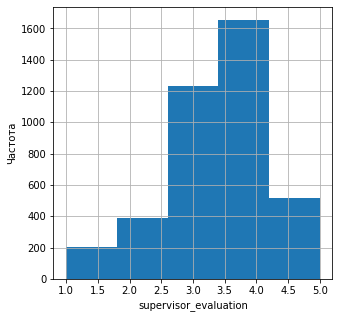

count    4000.000000
mean        3.474750
std         1.004049
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64


In [65]:
plot_histogram(train_quit, 'supervisor_evaluation', bins=5)

Распределение данных сходно с распределением данных из предыдущей задачи. Используется такая же пятибальная система. Медиана распределения соответствует оценке 4.

#### Ежемесячная зарплата сотрудника

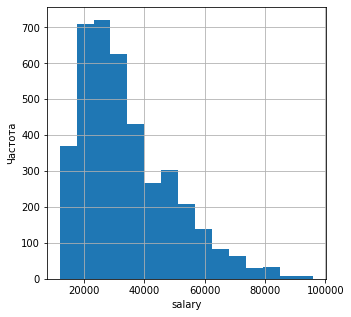

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64


In [66]:
plot_histogram(train_quit, 'salary', bins=15)

Распределение для зарплат также сходно с данными из предыдущей задачи. Зарплаты распределены от 12 тыс до 96 тыс, медиана составляет 30 тыс.

#### Анализ качественных признаков в тренировочной выборке

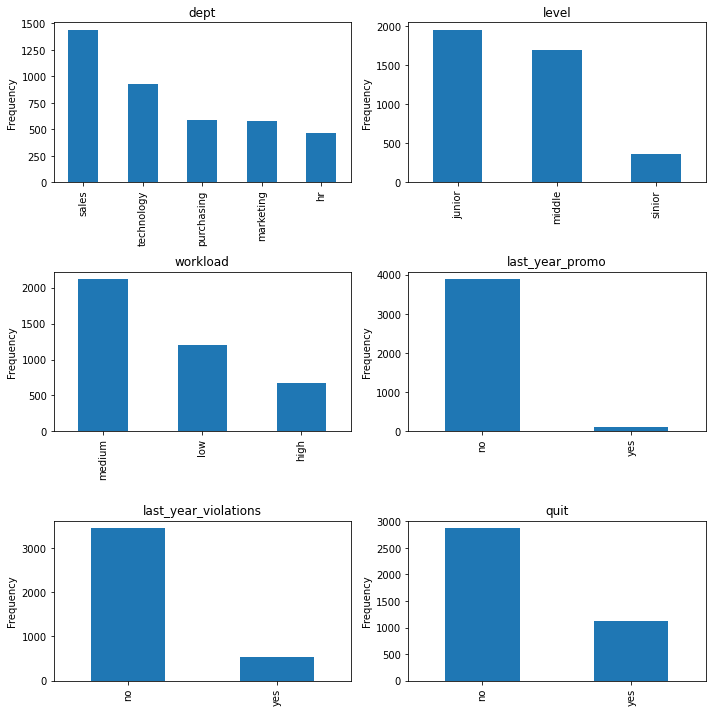

In [67]:
object_columns3 = train_quit.select_dtypes(include='object').columns

num_cols = 2 # количество столбцов
num_rows = 3 # строк

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10)) #создаем поле для графика
axes = axes.flatten() # преобразуем двухмерный массив, так как графиков 5 другого варианта не получилось

for i, col in enumerate(object_columns3): # рисуем график для каждого столбца
    ax=axes[i]
    train_quit[col].value_counts().plot(kind='bar', ax=axes[i], title=col)
    axes[i].set_ylabel('Frequency')
    axes[i].set_xlabel('')

plt.tight_layout() # настройка интервала между графиками
plt.show()

Распределения качественных признаков в данных train_quit сопоставимо с данными из предыдущей задачи.  
Целевой признак quit имеет дисбаланс классов - в данных представленно больше сотрудников, которые не попали под увольнение. 

**<span style='color: green;'>Вывод:  
Распределения данных в таблице train_quit сопостовимо с данными из задачи 1.  
Целевой признак quit качественный, представлен двумя значениями yes и no. Кроме того, целевой признак имеет дисбаланс классов.</span>**

### Исследование уволившихся сотрудников

Используя таблицу train_quit, найдем закономерности, которые характерны для уволившихся сотрудников.

Сначала проанализируем, как связано увольнение с другими качественными признаками.

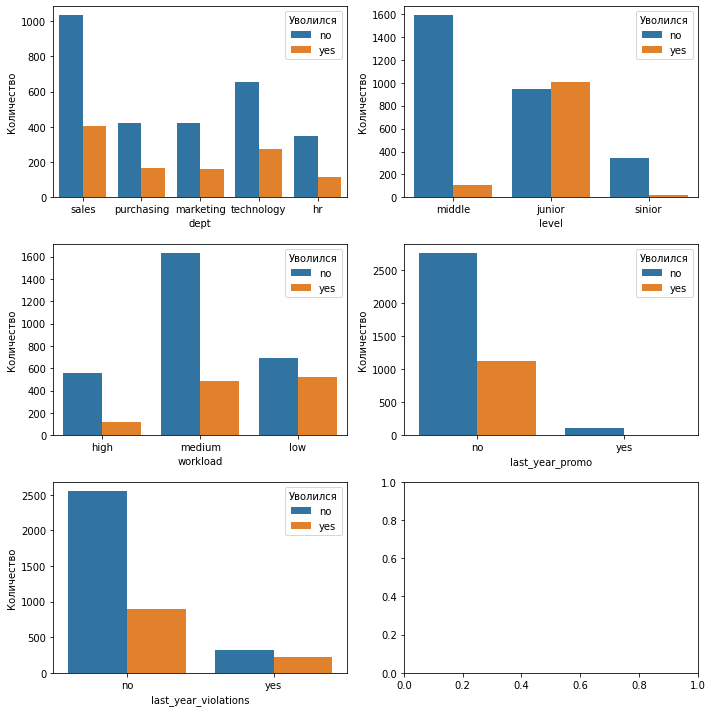

In [68]:
object_columns3 = train_quit.select_dtypes(include='object').columns

num_cols=2
num_rows=3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axes = axes.flatten() 

for i, column in enumerate(object_columns3):
    if column != 'quit':
        sb.countplot(x=column, hue='quit', data=train_quit, ax=axes[i])
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Количество')
        axes[i].legend(title='Уволился')

plt.tight_layout() 
plt.show()

Из полученных столбчатых диаграмм можно сделать следующие выводы:
* Увольнение слабо зависит от занимаемой должности. Для должностей, которых больше в данных, больше уволившихся сотрудников и наоборот.
* Увольнение зависит от уровня занимаемой должности, больше всего сотрудников увольняется с начальной должности junior, т.е. наибольшая текучисть кадров на должностях начального уровня.
* Увольняется больше всего сотрудников, которые менее загружены.
* Повышение также влияет на увольнение, сотрудники, которые получили повышение, не увольняются.  

Для проверки сделанных предположений дополнительно построим столбчатые диаграммы для соотношения уволившихся и не уволившихся сотрудников.

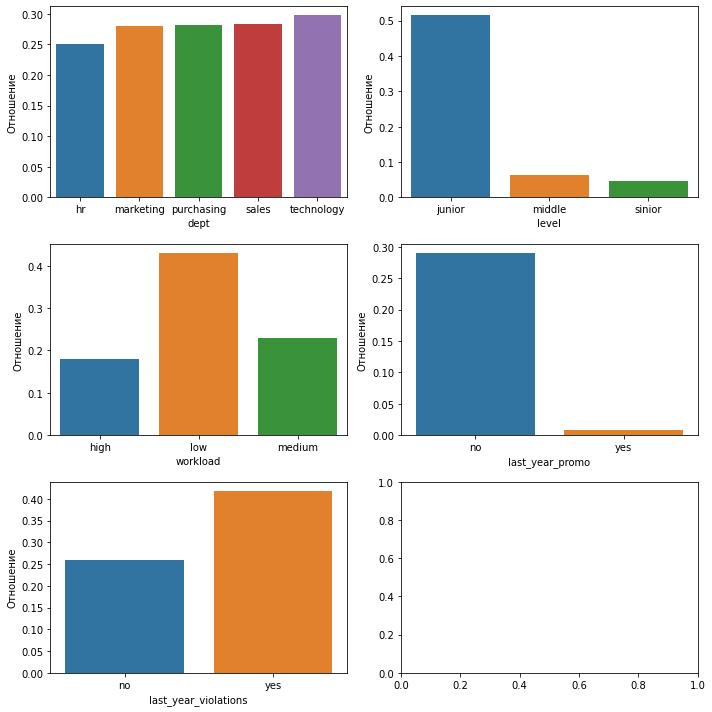

In [69]:
object_columns3 = train_quit.select_dtypes(include='object').columns

num_cols = 2
num_rows = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axes = axes.flatten() 

for i, column in enumerate(object_columns3):
    if column != 'quit':
        pivot_table = pd.pivot_table(train_quit, index=column, columns='quit', aggfunc='size')
        pivot_table.columns = ['no', 'yes']  
# расчет отношения уволившихся к общему числу сотрудников
        pivot_table['ratio'] = pivot_table['yes'] / (pivot_table['yes'] + pivot_table['no']) 
        
        plot_data = pivot_table['ratio'].reset_index()
        
        sb.barplot(x=column, y='ratio', data=plot_data, ax=axes[i])
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Отношение')

plt.tight_layout()
plt.show()        

Можно дополнить предыдущие выводы:
* Чуть больше увольняются специалисты technology, меньше всего hr.


Изучим, как увольнение связано с количественными признаками. Для этого сравним распределения количественных признаков для уволившися и не уволившихся сотрудников.

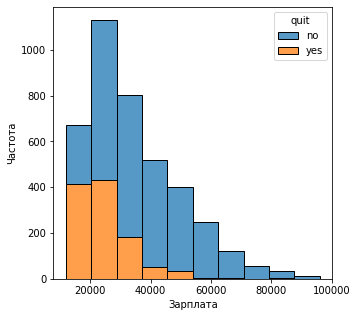

       count          mean           std      min      25%      50%      75%  \
quit                                                                           
no    2872.0  37702.228412  15218.977339  12000.0  25200.0  34800.0  46800.0   
yes   1128.0  23885.106383   9351.599505  12000.0  16800.0  22800.0  27600.0   

          max  
quit           
no    96000.0  
yes   79200.0  


In [70]:
plt.figure(figsize=(5, 5))
sb.histplot(data=train_quit, x='salary', hue='quit', multiple='stack', bins=10)
plt.xlabel('Зарплата')
plt.ylabel('Частота')
plt.show()
print(train_quit.groupby('quit')['salary'].describe())

Больше увольняется сотрудников с низкой зарплатой. 75% таких сотрудников получают зарплату до 28 тыс, т.е. ниже средней зарплаты не уволившихся сотрудников. Медиана зарплаты не уволившихся также выше, чем уволившихся.

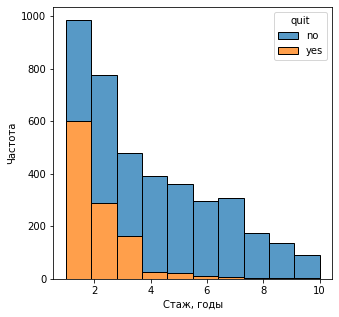

       count      mean       std  min  25%  50%  75%   max
quit                                                      
no    2872.0  4.430710  2.544635  1.0  2.0  4.0  6.0  10.0
yes   1128.0  1.844858  1.274920  1.0  1.0  1.0  2.0  10.0


In [71]:
plt.figure(figsize=(5, 5))
sb.histplot(data=train_quit, x='employment_years', hue='quit', multiple='stack', bins=10)

# Добавление меток и заголовка
plt.xlabel('Стаж, годы')
plt.ylabel('Частота')
plt.show()
print(train_quit.groupby('quit')['employment_years'].describe())

Больше увольняется сотрудников, проработавших в компании от одного до 2 лет.

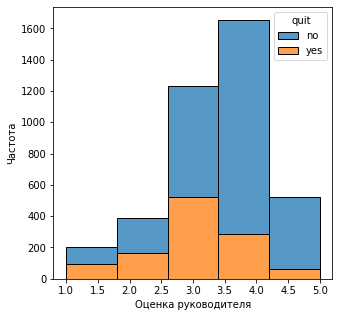

       count      mean       std  min  25%  50%  75%  max
quit                                                     
no    2872.0  3.643106  0.965295  1.0  3.0  4.0  4.0  5.0
yes   1128.0  3.046099  0.973291  1.0  3.0  3.0  4.0  5.0


In [72]:
plt.figure(figsize=(5, 5))
sb.histplot(data=train_quit, x='supervisor_evaluation', hue='quit', multiple='stack', bins=5)

# Добавление меток и заголовка
plt.xlabel('Оценка руководителя')
plt.ylabel('Частота')
plt.show()
print(train_quit.groupby('quit')['supervisor_evaluation'].describe())

В данном случае какой-либо закономерности не наблюдается. Распределения оценок уволившихся и не уволившихся сотрудников почти совпадают.

**<span style='color: green;'>Вывод:  
Теперь можно составить приблизительный портрет "уволившегося сотрудника".
Это сотрудник обычно занимает не высокую должность, работает в компании не очень давно, имеет не так много обязанностей, получает не большую зарплату. Есть небольшой перекос в сторону технического персонала. Значительно влияет повышение, сотрудники с повышением не увольняются.  
Таким образом, в основном это начинающий сотрудник компании.</span>** 

### Влияние уровня удовлетворенности сотрудника на его увольнение

Необходимо проверить утверждение, что уровень удовлетворенности сотрудника работой в компаниии влияет на то, уволится ли сотрудник.  
Для этого необходимо визуализировать и сравнить распределения признаков job_satisfaction_rate для ушедших и оставшихся сотрудников.

*по условию задачи необходимо использовать данные с обоими целевыми признаками тестовой выборки. Я это понял так, что необходимо объединить таблицы test_target_quit и таблицу test_target_job_satisfaction_rate по id    

In [73]:
test_target_quit.set_index('id', inplace=True) # убираем id индекс
test_target_quit.sort_index(inplace=True) # сортируем по инедуксу

In [74]:
test_target_quit.head(5) #проверка

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [75]:
test_target_sat.head(5)

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


In [76]:
step33 = pd.merge(test_target_quit, test_target_sat, left_index=True, right_index=True) # объединим две таблицы

In [77]:
step33.head() # проверка

,quit,job_satisfaction_rate
id,,
100298,no,0.80
100480,no,0.84
100503,no,0.79
100610,no,0.75
100692,no,0.69


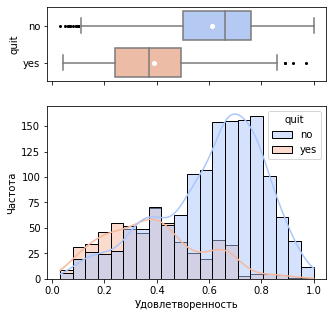

       count      mean       std   min   25%   50%     75%   max
quit                                                            
no    1436.0  0.612040  0.199367  0.03  0.50  0.66  0.7600  1.00
yes    564.0  0.387713  0.185784  0.04  0.24  0.37  0.4925  0.97


In [82]:
meanprops = {
    "marker": "o",
    "markerfacecolor": "white", 
    "markeredgecolor": "white",
    "markersize": 4
}

flierprops = {
    "marker": "o",
    "markerfacecolor": "black", 
    "markeredgecolor": "black",
    "markersize": 2
}

# palette = sb.color_palette("deep")
palette = sb.color_palette('coolwarm', n_colors=2)
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.30, .70)}, figsize=(5, 5))
sb.boxplot(data=step33, x = 'job_satisfaction_rate', y='quit', showmeans=True, meanprops=meanprops, orient='h', ax=ax_box, palette=palette, flierprops=flierprops)
sb.histplot(data=step33, x='job_satisfaction_rate', hue='quit', bins=20, ax=ax_hist, kde=True, palette=palette)
ax_box.set_xlabel('')
ax_hist.set_xlabel('Удовлетворенность')
ax_hist.set_ylabel('Частота')
plt.show()
print(step33.groupby('quit')['job_satisfaction_rate'].describe())

# такой код я использовал для анализа данных по своей работе, решил адаптировать и перенести сюда

Среднее и медиана уволившихся сотрудников соответствуют более низким значениям удовлетворенности сотрудников. 0.38 и 0.37 против 0.61 и 0.66.

Сравним статистически два распределения, будем использовать непараметрический тест Манна-Уитни. Выбор сделан был в пользу данного теста, так как выборки очень отличаются по размеру.

In [83]:
# разделим данные на две группы yes и no
yes_group = step33[step33['quit'] == 'yes']['job_satisfaction_rate']
no_group = step33[step33['quit'] == 'no']['job_satisfaction_rate']

# теста Манна-Уитни
u_statistic, p_value = stats.mannwhitneyu(yes_group, no_group, alternative='two-sided')

print(u_statistic, p_value)

167292.5 5.673072286850858e-93


Полученное значение p-value << 0.001 и меньше заданного уровня значимости (0.05), поэтому можно отвергнуть нулевую гипотезу и принять альтернативную гипотезу о том, что распределения отличаются и удовлетворенность сотрудников работой в компании влияет на то, уволится ли сотрудник.

Дополнительно посмотрим корреляцию между признаками.

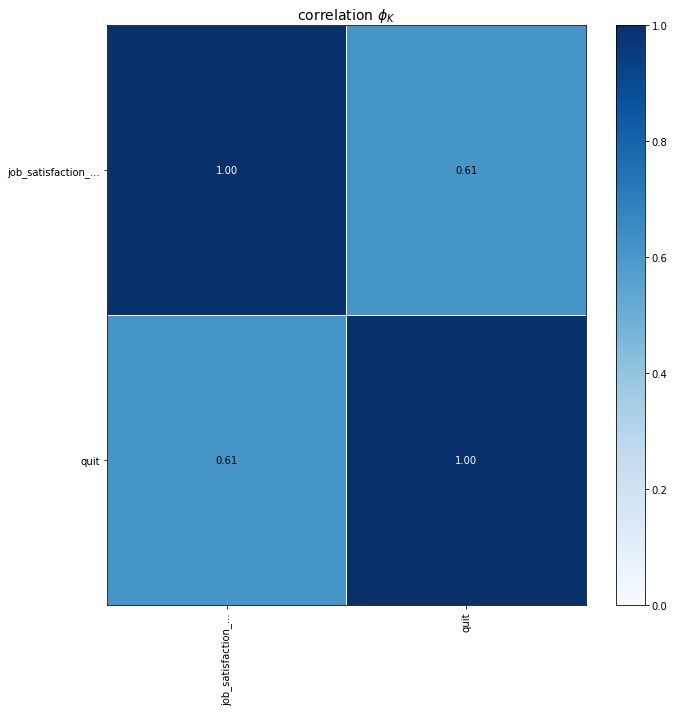

In [84]:
phik_overview = step33.phik_matrix(interval_cols=['job_satisfaction_rate'])
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10,10)
)
plt.tight_layout()

**<span style='color: green;'>Вывод:  
утверждение аналитиков оказалось верным, удовлетворенность сотрудника работой в компании влияет на то, уволится ли сотрудник.
Корреляция между признаками составляет 0.61.</span>** 

## Добавление нового входного признака

Добавляем job_satisfaction_rate, предсказанный лучшей моделью из первой задачи к входным признакам второй задачи (train_quit).

In [85]:
train_quit.head(5)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [86]:
train_quit.set_index('id', inplace=True)
train_quit.sort_index(inplace=True)

In [87]:
train_quit.head(5) # проверка

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes
100459,purchasing,junior,medium,3,no,no,3,21600,yes
100469,marketing,junior,medium,1,no,no,4,28800,no
100601,technology,middle,high,4,no,no,4,68400,no
100858,sales,junior,medium,2,no,no,4,25200,yes


In [88]:
job_sat_pres_train_quit = grid_tree.best_estimator_.predict(train_quit)

In [89]:
train_quit['job_satisfaction_prediction'] = job_sat_pres_train_quit

In [90]:
train_quit.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_prediction
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.408147
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.384597
100469,marketing,junior,medium,1,no,no,4,28800,no,0.633873
100601,technology,middle,high,4,no,no,4,68400,no,0.770490
100858,sales,junior,medium,2,no,no,4,25200,yes,0.769808


In [91]:
test_features.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_prediction
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.836224
100480,marketing,junior,low,4,no,no,4,16800,0.757995
100503,purchasing,middle,high,5,no,no,4,55200,0.713221
100610,sales,middle,medium,5,no,no,4,43200,0.814470
100692,sales,middle,high,6,no,no,4,48000,0.696646


**<span style='color: green;'>Вывод:  
В train_quit (данные для тренировки второй модели) есть столбец c предсказанным первой моделью уровнем удовлетворенности сотрудников.  
В test_features (тестовая выборка для второй модели) есть столбец с предсказанным первой моделью уровнем удовлетворенности сотрудников.</span>** 

Дополнительно, перед подготовкой данных посмотрим матрицу корреляций для train_quit, это поможет выбрать, какие признаки можно исключить, если модель будет плохо настраиваться.

In [92]:
phik_overview = train_quit.phik_matrix(interval_cols=['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_prediction'])


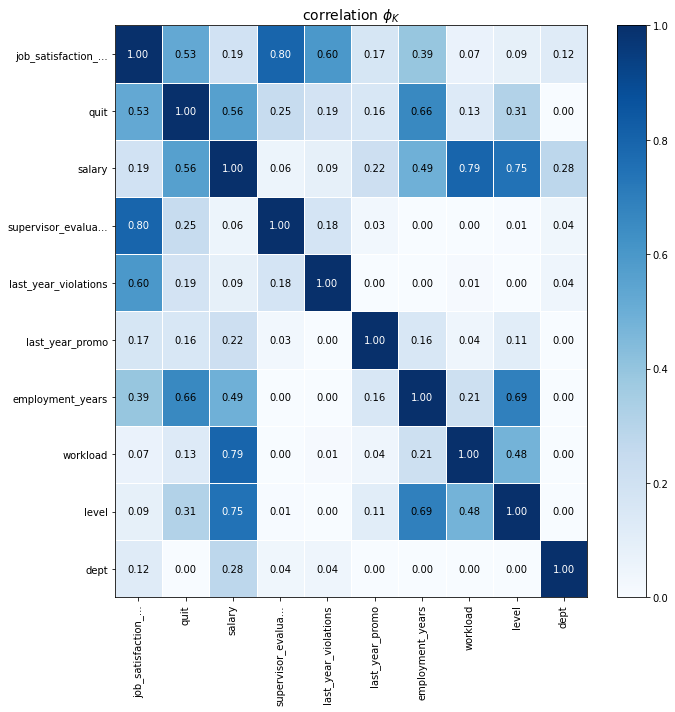

In [93]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10,10)
)
plt.tight_layout()

**<span style='color: green;'>Видно, что у увольнения нулевая корреляция с типом отдела, где работает сотрудник. Этот признак можно будет сразу исключить из модели.</span>**

## Подготовка данных

Перед началом построения пайплайна, проверим, что id сотрудников перенесены в индексы и таблицы отсортированны по индексу.

In [94]:
train_quit.head(5)#

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_prediction
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.408147
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.384597
100469,marketing,junior,medium,1,no,no,4,28800,no,0.633873
100601,technology,middle,high,4,no,no,4,68400,no,0.770490
100858,sales,junior,medium,2,no,no,4,25200,yes,0.769808


In [95]:
test_features.head(5)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_prediction
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.836224
100480,marketing,junior,low,4,no,no,4,16800,0.757995
100503,purchasing,middle,high,5,no,no,4,55200,0.713221
100610,sales,middle,medium,5,no,no,4,43200,0.814470
100692,sales,middle,high,6,no,no,4,48000,0.696646


In [96]:
test_target_quit.head(5)

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


Построим pipeline для подготовки данных.  
Будем использовать два кодировщика OrdinaryEncoder для порядковых признаков и OneHotEncoder для номинативных.  
В данной задаче целевой признак качественный, его также необходимо закодировать. Для этого понадобится кодировщик LabelEncoder.  
Для заполнения пропусков будем использовать SimpleImputer, пропуски заполним наиболее частыми значениями.  
Добавим в ColumnTransformer параметр remainder='drop', чтобы исключить данные, которые не вошли в кодировщик, например, dept.

In [97]:
# задаем параметры для разделения данных
RANDOM_STATE = 42 
TEST_SIZE = 0.25

X2 = train_quit.drop(['quit'], axis=1)  # признаки (features)
y2 = train_quit['quit'] 

# создаем LabelEncoder
label_encoder = LabelEncoder()

y2 = label_encoder.fit_transform(y2)   

# создаем списки с названиями признаков

ohe_columns = ['last_year_promo', 'last_year_violations'] # кодируем номинативные признаки
ord_columns = ['level', 'workload'] # кодируем порядковые признаки
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_prediction'] # кодируем количественные признаки

# подготовка данных

# подготовка признаков из списка ohe_columns: заполняем пропуски наиболее частыми значениями и кодируем переменные OneHotEncoder
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown = 'ignore', sparse_output = False))
    ]
)

# подготовка признаков из списка ord_columns: заполнение пропусков и кодирование переменных OrdinaryEncoder
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
      ('ord', OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],
                    ['medium', 'low', 'high'],
                ],
                handle_unknown='use_encoded_value' , unknown_value=np.nan
      )
      ),
      ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
      ]
)

# создаем общий пайплайн для подготовки данных и модель
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='drop' # Добавляем строчку, чтобы все признаки, которые не попали в кодировщик не использовались
                     # например, dept
)
# создаем итоговый паплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

## Обучение моделей

Необходимо обучить минимум три модели классификации, минимум для двух подобрать гиперпараметры.  
Было выбрано четыре модели: DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC. Для каждой модели было выбрано несколько гиперпараметров. 
В данной задаче метрикой оценки качества модели выступает ROC-AUC.

In [98]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 10),
        'models__max_features': range (2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],  
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },

    # словарь для модели KNeighborsClassifier() 

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()], 
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },

    # словарь для модели LogisticRegression()

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range (1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]
    },

    # словарь для модели SVC()

    {
        'models': [SVC(probability=True, random_state=RANDOM_STATE)],
        'models__C':[0.1, 2, 5, 10],
        'models__kernel':['rbf', 'linear'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()],
        'preprocessor__ohe': [ohe_pipe],
        'preprocessor__ord': [ord_pipe]

    }
]
# будем использовать GridSearch

grid_tree2=GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise',
)

grid_tree2.fit(X2, y2)

print('Лучшая модель и её параметры:\n\n', grid_tree2.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_tree2.best_score_)
print('Лучшие гиперпараметры модели:', grid_tree2.best_params_)



Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
 

In [99]:
model_cv_result2 = pd.DataFrame(grid_tree2.cv_results_)
model_cv_result2 = model_cv_result2.sort_values(['rank_test_score'])
pd.set_option('display.max_colwidth', None)
model_cv_result2[['mean_test_score', 'rank_test_score', 'params', 'std_test_score']].head(5)

,mean_test_score,rank_test_score,params,std_test_score
75,0.930898,1,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 7, 'preprocessor__num': MinMaxScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.013394
74,0.930898,1,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 7, 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.013394
71,0.930756,3,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 5, 'preprocessor__num': MinMaxScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.015574
70,0.930756,3,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 6, 'models__max_features': 5, 'preprocessor__num': StandardScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.015574
151,0.930199,5,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 4, 'preprocessor__num': MinMaxScaler(), 'preprocessor__ohe': (SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__ord': (SimpleImputer(strategy='most_frequent'), OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['medium', 'low', 'high']], handle_unknown='use_encoded_value', unknown_value=nan), SimpleImputer(strategy='most_frequent'))}",0.007604


Лучшей моделью на тренировочных данных оказалась логистическая регрессия со следующими гиперпараметрами: С=4, l1 регуляризация, масштабирования MinMaxScaler().

Проверим данную модель на тестовой выборке. На тестовой выборке метрику ROC-AUC уже считаем по вероятности классов

In [100]:
y_test_pred = grid_tree2.predict_proba(test_features)

In [101]:
print('Площадь ROC-кривой:', roc_auc_score(test_target_quit['quit'], y_test_pred[:,1]))

Площадь ROC-кривой: 0.9225260030818465


Значение метрики на тестовой выборке для лучшей модели соответсвует условию задачи ROC-AUC>=0.91

### Важность признаков

Изучим важность признаков, это позволит впоследствии сделать более весомые выводы для бизнеса.  
Для этого будем использовать столбчатую диаграмму SHAP, которая отражает общий вклад признаков в прогнозы модели.

In [102]:
X_test_transform = grid_tree2.best_estimator_.named_steps['preprocessor'].transform(test_features)
masker = shap.maskers.Independent(X_test_transform)
explainer = shap.Explainer(grid_tree2.best_estimator_.named_steps['models'].predict, masker, seed=RANDOM_STATE)
shap_values = explainer(X_test_transform)

In [103]:
preprocessor = grid_tree2.best_estimator_.named_steps['preprocessor']

In [104]:
feature_names = preprocessor.get_feature_names_out()
feature_names = feature_names.tolist()
shap_values_new = shap_values
shap_values_new.feature_names = feature_names

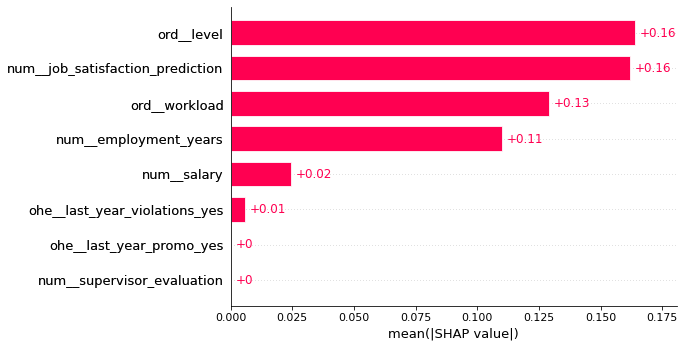

In [105]:
shap.plots.bar(shap_values_new, max_display=18)

Наиболее важными признаками для увольнения сотрудника с точки зрения модели являются:  
удовлетворенность сотрудника, предсказанная ранее,  
уровень занимаемой должности,  
длительность работы в компании,  
зарплата,  
уровень загруженности сотрудника,  
оценка качества работы сотрудника по системе компании.

## Выводы

Лучшей моделью для предсказания увольнения сотрудника оказалась модель логистической регрессии. Параметры лучшей модели следующие: l1 регуляризация, С=4, масштабирование в диапазоне от минимума до максимума (MinMaxScaler).

Модель логистической регрессии могла оказаться лучшей, так как l1-регуляризация позволила ей лучше отфильтровать слабокоррелированные признаки, такие признаки все равно оставались после удаления dept. Это видно и из распределения признаков по важности, куда вошли признаки с корреляцией выше 0.2.

# Общий вывод

В данном проекте были поставлены следующие задачи:  
Построить модель, которая сможет предсказать уровень удовлетворенности сотрудника компании на основе данных, которые предоставила компания "Работа с заботой".  
Построить модель, которая сможет на основе данных этой же компании предсказать увольнение сотрудника.
Для реализации поставленных задач компания предоставила данные для тренировки моделей и для их тестирования. 
В ходе реализации первой задачи: 
* Данные были подготовлены.
  * Были выявлены пропуски в данных. Пропуски в данных были закодированы по-разному.  
* Проведен исследовательский анализ данных.
  * В данных больше представлены сотрудники с небольшим стажем работы. Чем выше стаж, тем меньше сотрдуников.
  * Компания проводит свою оценку сотрудников по пятибальной шкале. Наиболее распростроненная оценка 4.
  * Большая часть сотрудников получает зарплату до 43 тыс. При этом медиана заплаты составляет 30 тыс.
  * Целевая переменная уровень удовлетворенности сотрудников количественная, распределена от 0 до 1, где 1 это максимальная удовлетворенность сотрудника. Медиана составляет 0.5.
  * В данных больше всего представлены сотрудники, которые работают в отделе продаж.
  * По уровню больше в данных начинающих сотрудников.
  * В данных значительно больше сотрудников, которые не попадали под повышение. Это логично, так как большая часть сотрудников только начали работать в компании.
  * Сотрудники в основной своей массе не нарушают трудовой договор.
  * Наборы данных для тренировочной выборки сопостовимы по своей структуре.
* Корреляционный анализ показал, что оценка, которую дает компания сотруднику, хорошо соотносится с уровнем удовлетворенности сотрудника. Хуже всего с уровнем удовлетворенности связана загруженность сотрудника, что не очень удивительно, так как зарплата сотрудника хорошо коррелирует с его загруженностью.
* Подготовка модели.
  * В данных представленны количественные признаки и два типа категориальных (порядковые и номинативные). Для кодирования порядковых признаков (уровень занимаемой должности и уровень загруженности сотрудника) был выборан OrdinalEncoder. Для кодирования номинативных признаков использовался OneHotEncoder. Для обработки пустых значений использовали SimplerImputer.
* Обучение модели.
  * Так как целевой признак количественный, необходимо использовать регрессионные модели. Использовали две модели: модель опорных векторов (SVR) и модель дерева решений (DicisionTreeRegression). Для оценки качества модели использовали SMAPE метрику.
  * Лучший результат показала SVR модель. Параметры лучшей модели следующие: нелинейное ядро радиальной базисной функции (Radial Basis Function), гиперпараметр ~С=5~ C=2, StandardScaler. Значение SMAPE на тренировочной выборке составило 14.9, на тестовой 14.01.
  
В ходе реализации второй задачи:
* Данные были подготовлены. В новых данных пропусков, явных и неявных дубликатов выявлено не было.
* Исследовательский анализ показал, что распределения признаков в данных сопостовимо с данными из первой задачи.
* На основе новых данных был составлен "портрет" уволившегося сотрудника:
  Это сотрудник, занимающий не высокую должность в компании, работающий не очень давно, не сильно заруженный и получающий не большую зарплату. На увольнение значительно влияет повышение, сотрудники с повышением не увольняются.
* Была выявлена связь между уровнем удовлетворенности сотрудника и его увольнением. Чем ниже уровень удоблетворенности сотрудника, тем вероятнее его увольнение из компании.
* Основываясь на новой выявленной закономерности в таблицы с входными и тестовыми признаками был добавлен признак удовлетворенности сотрудника, составленный на основе предсказанная первой модели.
* Подготовка данных для второй модели.
  * Целевой признак второй модели является качественным, поэтому необходимо использовать модели классификации.
  * Для кодирования признаков было использовано два кодировщика OrdinalEncoder и OneHotEncoder как в первой модели, дополнительно целевой признак был закодирован LabelEnckoder.
  * Обработка пропусков была включена в pipeline.
  * Из признаков для обучения модели был убран один признак (отдел, в котором работает сотрудник), который показал нудевую корреляцию с целевой переменной.
* Обучение модели.
  * Для обучения были взяты четыре модели классифакации: деревья решений (DecisionTreeClassifier), метод ближайших соседей (KNeighborsClassifier), логистическая регрессия (LogisticRegression), модель опорных векторов (SVC). Для кажлой модели подбирались гиперпараметры. Для оценки качества модели использовали метрику roc-auc.
  * Лучший результат показала модель логистической регресии. Со следующими гиперпараметрами: С=4, l1 регуляризация, масштабирования MinMaxScaler(). Значение метрики roc-auc на тренировочной выборке составило 0.93, на тестовой выборке 0.92.
 

Предложения для бизнеса:
* Наибольшая текучесть кадров наблюдается для начинающих сотрудников. Следовательно, необходимы дополнительные меры для удержания нового сотрудника в компании, если есть необходимость в сотрудниках.
* Так как в компании достаточно хорошая связь между зарплатой и загруженностью, удержать и мотивировать нового сотрудника можно, используя оплату сверхурочной работы. Если нет необходимости в доп работе, возможно, положительную роль в удержании нового сотрудника сыграет хороший соцпакет.
* Использованная оценка уровня удовлетворенности сотрудника, выбранная компанией, оказывается одним из основных признаков для предсказания увольнения. Компании имеет смысл использовать эту оценка в дальнейшем.
* Уровень удовлетворенности сотрудников связан с оценкой качества работы этого сотрудника, которую дает руководитель. Таким образом, используемая система оценок в компании, работает хорошо.
* Для предсказания увольнения оказываются важны признаки, которые опять же указывают на необходимость компании обратить внимание на рядовых новых сотрудников.
* Уровень удовлетворенности сотрудников зависит от зарплаты, должности и уровня загруженности сотрудников. Компании стоит обращать внимание на эти параметры. Возможно, как уже было написано выше, необходимы дополнительные меры по поддрежанию сотрудников начального уровня, если нет возможности регулировать эти параметры.